# Visualisation frameworks in Python

Documentation sources:
*  [plotnine API reference](https://plotnine.readthedocs.io/en/stable/api.html). 
*  [https://matplotlib.org](https://matplotlib.org)
*  [https://seaborn.pydata.org](https://seaborn.pydata.org)


There are many visualisation frameworks in Python. 
* A library `matplotlib` is a common foundation on which many frameworks are built.
* The best library for data visualisation is `ggplot2` in `GNU R` as it uses declarative language and its visual appearance has been polished in many years. Fortunately, there is a Python port `plotnine` that is 95% feature complete.
* If you do not like the declarative programming style of `ggplot`, you can always use `matplotlib` and `seaborn`.


  

## I. A simple example how to use plotnine 


Philosophy behind ggplot: 

* You do not specify the exact details of the visualisation.
* Instead, you specify how you want the data to be visualised.


This leads to the standard usage pattern:
1. You specify a dataframe that you want to visualise. 
2. You specify what type of graph you are expecting see.
3. You provide additional details only if there is a need for that.  

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
from plotnine.data import mtcars
from pandas import read_csv
from pandas import DataFrame

To draw a simple scatter plot over the data:
* Specify a dataframe. 
* Specify what type of graph to plot. 

The quantities you want to visualise can be specified either in the first step or in the second step.
* I personally prefer to specify these quantities in the second step for clarity. 
* You can always write the entire specification as a single expression as the interface supports also method chaining.
* However, line-by-line assignements are better for tweaking the details in practice. 

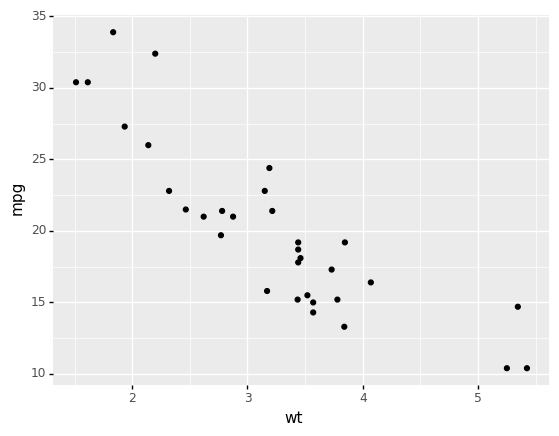

<ggplot: (347009220)>

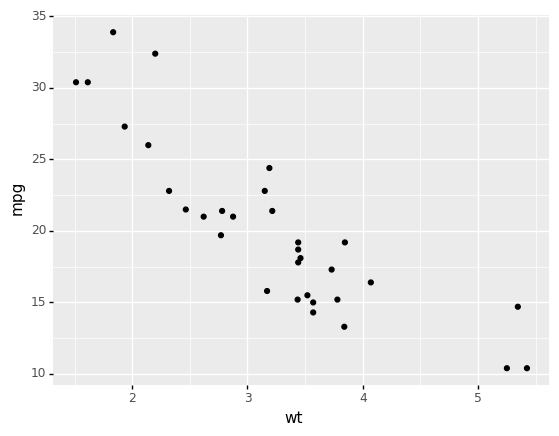

<ggplot: (347025439)>

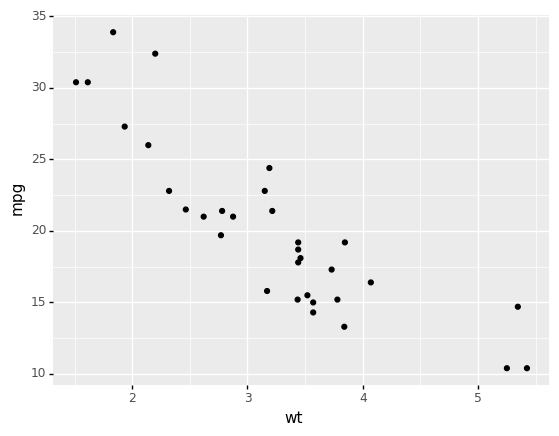

<ggplot: (347202720)>

In [2]:
# Idiomatic single-liner  
display(ggplot(mtcars, aes('wt', 'mpg')) + geom_point())

# The first step specifies data and quantities to be visualised
p = ggplot(mtcars, aes('wt', 'mpg'))
p = p + geom_point()
display(p)

# The first step specifies only the data 
p = ggplot(data=mtcars)
p = p + geom_point(mapping=aes('wt', 'mpg'))
display(p)

## II. An introduction to basic concepts 

Lets draw performance results for several machine-learning experiments:
* We need to draw scatter plot and line plot.
* We need to colour lines and points according to an experiment. 

### First visualisation just shows the shape of the data

* To be safe we convert experiment type to a categorical value.
* We load the data and spacify two graphs. **They will be put on the same graph.**
* A single ggplot object always describes a single graph or other visualisation element.

,experiment,size,training_accuracy,test_accuracy
0,1,10.6,0.993,0.785
1,1,20.6,0.987,0.799
2,1,30.1,0.984,0.808
3,1,40.6,0.980,0.814
4,1,49.6,0.978,0.819


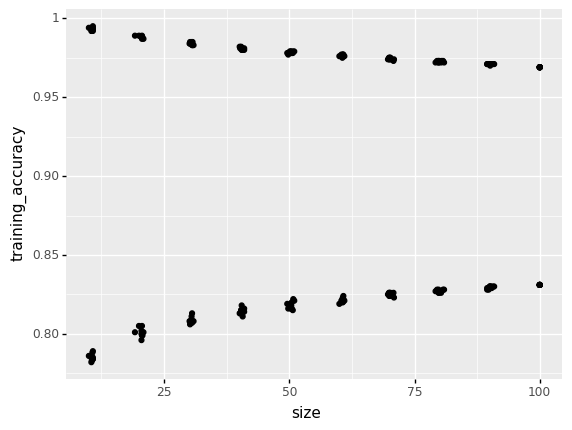

<ggplot: (347331714)>

In [3]:
df =(read_csv('performance-results.csv')
     .assign(experiment = lambda df: df['experiment'].astype('category'))
     .assign(size = lambda df: df['size'] * 100))
display(df.head())


p = ggplot(df)
p = p + geom_point(aes(x='size', y='training_accuracy')) 
p = p + geom_point(aes(x='size', y='test_accuracy'))
p

### Second visualisation to capture statistical fluctuations 

* Statistical fluctuations can be visualised with box and violin plots.
* Visualisations are specified as geometric objects `geom_boxplot` and `geom_violin`.
* Each visualisation expects to see a mapping specified as `aes(...)` object.
* If the mapping is not specified, it uses mapping defined in `ggplot` function call.
* The mapping specifies which columns are used to compute the aestetics in the visualisation output.
  * Aestetics `x` and `y` specifie locations in x-axis and y-axis.
  * Aestetics `size`, `color`, `fill`, `linetype` and `shape` the properties of points or lines. 
  * Different visualisations use different aestetics. Look it up from the [plotnine API reference](https://plotnine.readthedocs.io/en/stable/api.html).   
 

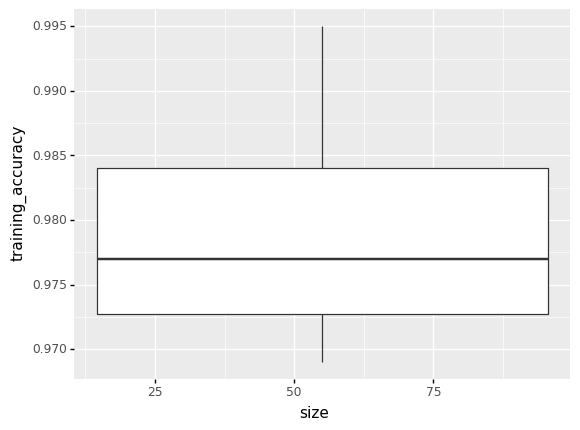

<ggplot: (347384170)>

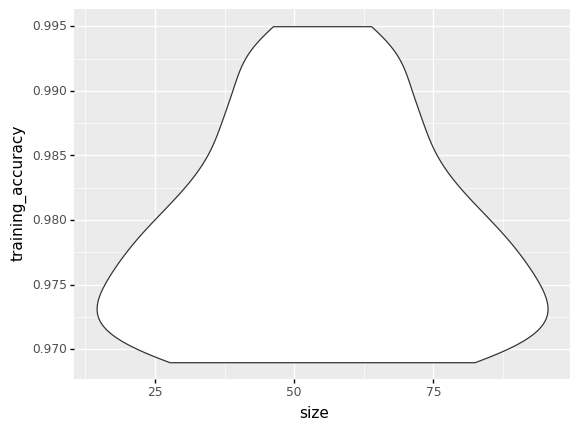

<ggplot: (347387510)>

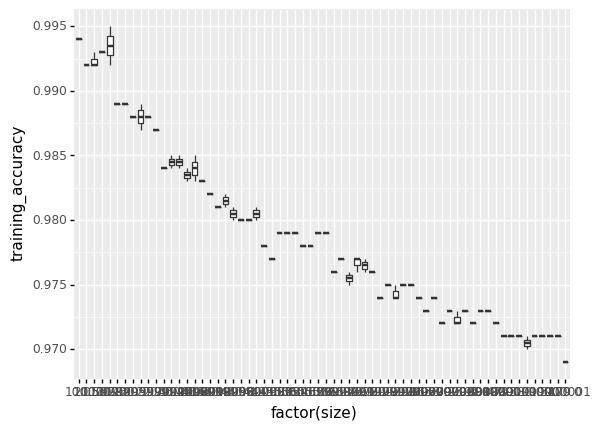

<ggplot: (347429539)>

In [4]:
# The first try fails spectacularly. We somehow get only one boxplot
# The x argument must be categorical but it is not in our data.
p = ggplot(df)
p = p + geom_boxplot(aes(x='size', y='training_accuracy')) 
display(p)

# The second try also fails spectacularly. We somehow get only one violin plot
# The x argument must be categorical but it is not in our data.
p = ggplot(df)
p = p + geom_violin(aes(x='size', y='training_accuracy')) 
display(p)


# The third try where we say that x must be converted to cathegorical value works.
# However, the result is bad as there are too many values for the size.  
p = ggplot(df)
p = p + geom_boxplot(aes(x='factor(size)', y='training_accuracy')) 
display(p)

### Third visualisation with precomputed statistics

* Altenatively it is possible to use error bars derived from mean and variance values.
* If there a more data then quantiles are also good way to show variance. 
* As size values are fluctuating around multiples of then we must discretise then in order to make right groups.
* This allows us to compute aggregates for individual groups.
* Constant aestetic values must be specified outside `aes(...)` block.
* No legends are drawn for such constant aesteric values.

In [5]:
sdf = (df
       .assign(group = lambda df: pd.cut(df['size'], bins = [10*i+5 for i in range(11)]))
       .groupby('group')
       .aggregate(size_mean=('size', np.mean), 
                  size_std=('size', np.std), 
                  training_mean=('training_accuracy', np.mean), 
                  training_std=('training_accuracy', np.std),
                  test_mean=('test_accuracy', np.mean),
                  test_std=('test_accuracy', np.std),
                 ))
display(sdf)

,size_mean,size_std,training_mean,training_std,test_mean,test_std
group,,,,,,
"(5, 15]",10.62,0.244040,0.9930,0.001054,0.7850,0.002160
"(15, 25]",20.41,0.481779,0.9881,0.000738,0.8008,0.002741
"(25, 35]",30.50,0.258199,0.9840,0.000816,0.8085,0.002014
"(35, 45]",40.54,0.298887,0.9808,0.000789,0.8142,0.001932
"(45, 55]",50.37,0.437290,0.9784,0.000699,0.8181,0.002378
"(55, 65]",60.63,0.271006,0.9763,0.000675,0.8213,0.001494
"(65, 75]",70.19,0.384274,0.9743,0.000675,0.8250,0.001054
"(75, 85]",80.03,0.533437,0.9725,0.000527,0.8271,0.000876
"(85, 95]",90.13,0.464399,0.9709,0.000316,0.8294,0.000843


Lets draw first averaged lines without error bars.

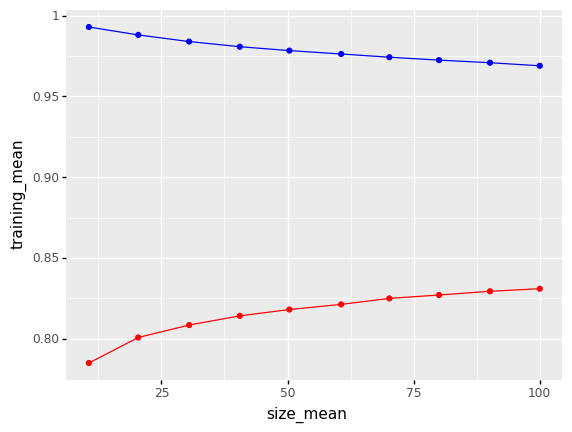

<ggplot: (347203895)>

In [6]:
p = ggplot(sdf) 
p = p + geom_point(aes(x='size_mean', y='training_mean'), color='blue')
p = p + geom_line(aes(x='size_mean', y='training_mean'), color='blue')
p = p + geom_point(aes(x='size_mean', y='test_mean'), color='red')
p = p + geom_line(aes(x='size_mean', y='test_mean'), color='red')
p

To draw error bars we need to compute more values. As the bars are very tight we draw them two standard deviations appart.

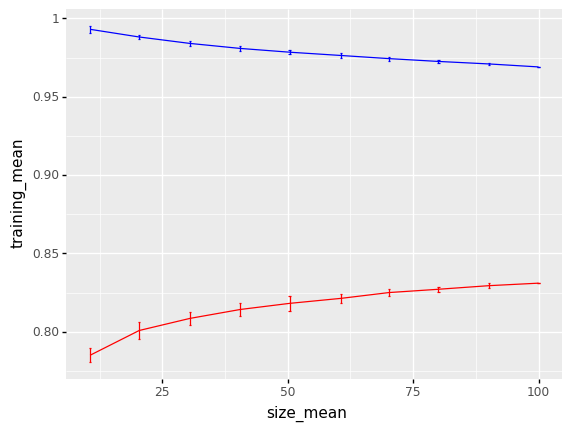

<ggplot: (348877457)>

In [7]:
sdf=sdf.assign(
    training_ue = lambda df: df['training_mean'] + 2 * df['training_std'],
    training_le = lambda df: df['training_mean'] - 2 * df['training_std'],
    test_ue = lambda df: df['test_mean'] + 2 * df['test_std'],
    test_le = lambda df: df['test_mean'] - 2 * df['test_std'])

# Note that order of terms is important, as it determines when something is drawn
p = ggplot(sdf) 
p = p + geom_errorbar(aes(x = 'size_mean', ymin = 'training_le', ymax = 'training_ue'), color='blue')
p = p + geom_line(aes(x='size_mean', y='training_mean'), color='blue')
p = p + geom_errorbar(aes(x = 'size_mean', ymin = 'test_le', ymax = 'test_ue'), color='red')
p = p + geom_line(aes(x='size_mean', y='test_mean'), color='red')
p

## III. Grouping and lengends

The previous visualisation was without legends and we had to do a lot of manual work to specify what we wanted to plot. There is an alternative way but we need to reshape the data aka tidy data.
* Observation consists of size, experiment, dataset type and performance. 
* With this structure we can do necessary data aggregation more naturally.
* We need to group data to be visualised into two groups: training and test.
* This is achieved by specifying aestetic value inside `aes(...)` block.

In [8]:
df.head()

,experiment,size,training_accuracy,test_accuracy
0,1,10.6,0.993,0.785
1,1,20.6,0.987,0.799
2,1,30.1,0.984,0.808
3,1,40.6,0.980,0.814
4,1,49.6,0.978,0.819


In [9]:
df.melt(id_vars=['experiment', 'size'], var_name='data_type', value_name='accuracy')

,experiment,size,data_type,accuracy
0,1,10.6,training_accuracy,0.993
1,1,20.6,training_accuracy,0.987
2,1,30.1,training_accuracy,0.984
3,1,40.6,training_accuracy,0.980
4,1,49.6,training_accuracy,0.978
...,...,...,...,...
195,10,60.6,test_accuracy,0.820
196,10,70.8,test_accuracy,0.826
197,10,80.3,test_accuracy,0.826
198,10,90.9,test_accuracy,0.830


In [10]:
tmp =(df
      .melt(id_vars=['experiment', 'size'], var_name='data_type', value_name='accuracy')
      .assign(data_type=lambda df: df['data_type'].astype('category')
              .cat.rename_categories({'training_accuracy':'Training', 
                                      'test_accuracy':'Test' }))
      .assign(group = lambda df: pd.cut(df['size'], bins = [10*i+5 for i in range(11)]))
     )

display(tmp.head())

sdf = (tmp
       .groupby(['data_type', 'group'])
       .aggregate(size_mean=('size', np.mean), 
                  size_std=('size', np.std), 
                  accuracy_mean=('accuracy', np.mean), 
                  accuracy_std=('accuracy', np.std))
       .reset_index()
       .assign(accuracy_ue = lambda df: df['accuracy_mean'] + 2 * df['accuracy_std'],
               accuracy_le = lambda df: df['accuracy_mean'] - 2 * df['accuracy_std']))
display(sdf.head())

,experiment,size,data_type,accuracy,group
0,1,10.6,Training,0.993,"(5, 15]"
1,1,20.6,Training,0.987,"(15, 25]"
2,1,30.1,Training,0.984,"(25, 35]"
3,1,40.6,Training,0.980,"(35, 45]"
4,1,49.6,Training,0.978,"(45, 55]"


,data_type,group,size_mean,size_std,accuracy_mean,accuracy_std,accuracy_ue,accuracy_le
0,Test,"(5, 15]",10.62,0.244040,0.7850,0.002160,0.789320,0.780680
1,Test,"(15, 25]",20.41,0.481779,0.8008,0.002741,0.806281,0.795319
2,Test,"(25, 35]",30.50,0.258199,0.8085,0.002014,0.812528,0.804472
3,Test,"(35, 45]",40.54,0.298887,0.8142,0.001932,0.818064,0.810336
4,Test,"(45, 55]",50.37,0.437290,0.8181,0.002378,0.822856,0.813344


* Lets reconstuct the last graph wihout colors using only `group` attribute in the `aes(...)` block.
* Data is split into two groups and graphs are drawn but no legends are created.

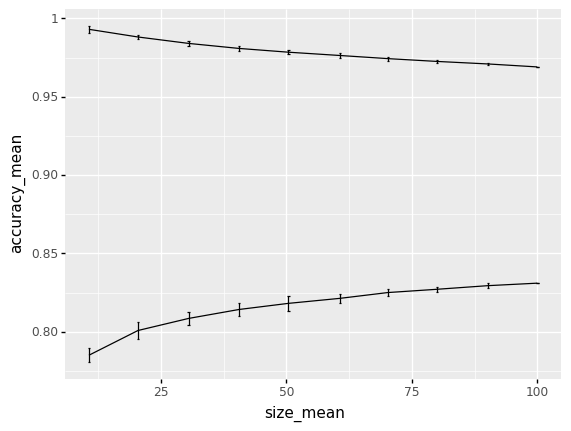

<ggplot: (348901211)>

In [11]:
p = ggplot(sdf) 
p = p + geom_errorbar(aes(x = 'size_mean', ymin = 'accuracy_ue', ymax = 'accuracy_le', group='data_type'))
p = p + geom_line(aes(x='size_mean', y='accuracy_mean', group='data_type'))
p

* Lets reconstuct the last graph wihout colors using 'color' and `linestyle` attributes in the `aes(...)` block.
* Data is split into two groups and graphs are drawn and appropriate legends are created.

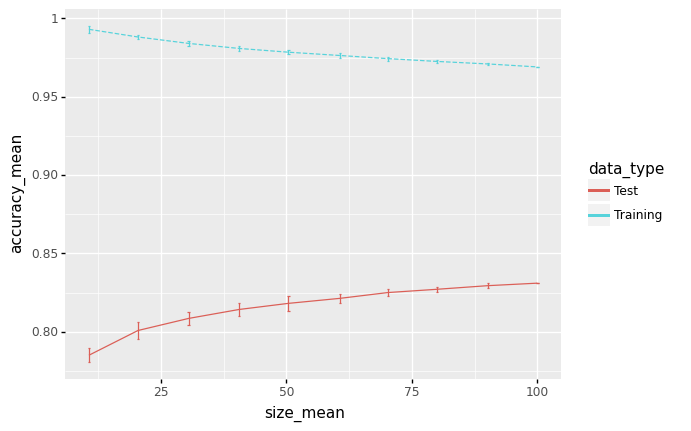

<ggplot: (348873256)>

In [12]:
p = ggplot(sdf) 
p = p + geom_errorbar(aes(x = 'size_mean', ymin = 'accuracy_ue', ymax = 'accuracy_le', color='data_type'))
p = p + geom_line(aes(x='size_mean', y='accuracy_mean', color='data_type', linetype='data_type'))
p

## IV. Finetuning visualisation details

Now it is time to correct axis layout and other more subtle visualisation options: 
* Let us correct axis name and control the y-axis range. 
* Let us correct axis name and use use percentages in the x-axis label.
* For that we need to work with scales. There are gazillion options in [the ggplot API](https://plotnine.readthedocs.io/en/stable/api.html#scales). 

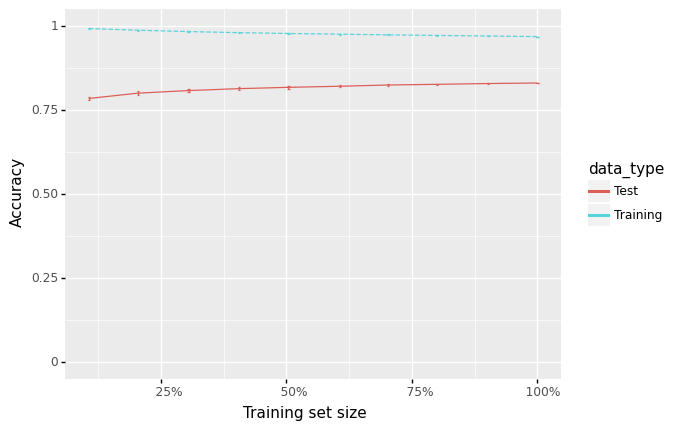

<ggplot: (350320860)>

In [13]:
p = ggplot(sdf) 
p = p + geom_errorbar(aes(x = 'size_mean', ymin = 'accuracy_ue', ymax = 'accuracy_le', color='data_type'))
p = p + geom_line(aes(x='size_mean', y='accuracy_mean', color='data_type', linetype='data_type'))
p = p + scale_x_continuous(
    name = 'Training set size', 
    labels = lambda np_array: ["{:6.0f}%".format(label) for label in np_array])
p = p + scale_y_continuous(name = 'Accuracy', limits = (0,1))
p    

## V. Faceting and marginal plots

Sometimes you want to place graphs side by side based on hyperparameters: 
* This is called faceting in `ggplot` terms.
* The modifier `facet_wrap` is meant to visualise different hyperparameter value complects.
* The modifier `facet_wrap([par_1, ..., par_k])` stitches plots into a grid and adds a single label panel on top.
* The modifier `facet_grid` is meant to visualise 2D dependence on hyperparameters.
* The modifier `facet_grid([''row_paramter, 'colum_parameter'])` stitches plots into a grid and add horozontal and vertical label panels. 

Sometimes you want to combine to show the dependence between two variables together with their marginals:
* The corresponding visualisation is specified as a geometric object `geom_rug`.
* This visualisation places observations on the rugs of the axis.
* If you want to more advanced subplots then you are out of luck so far although a we have a new hope: 
  * [plotnine: How to draw subplots? #46](https://github.com/has2k1/plotnine/issues/46)
  * [patchworklib: Might be the solution for subplot layouts](https://github.com/ponnhide/patchworklib)

/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


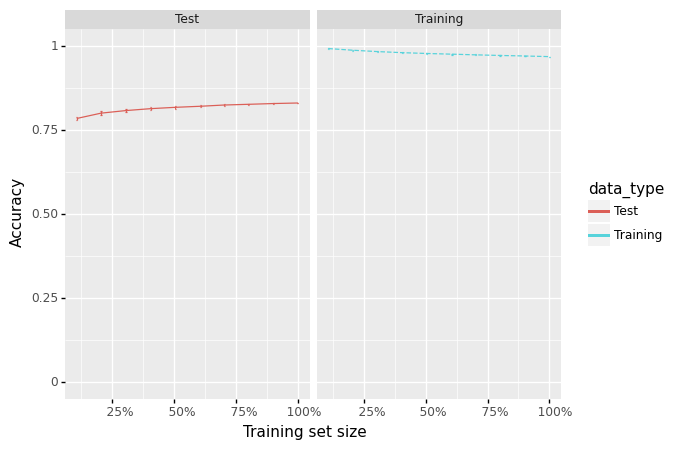

<ggplot: (350323975)>

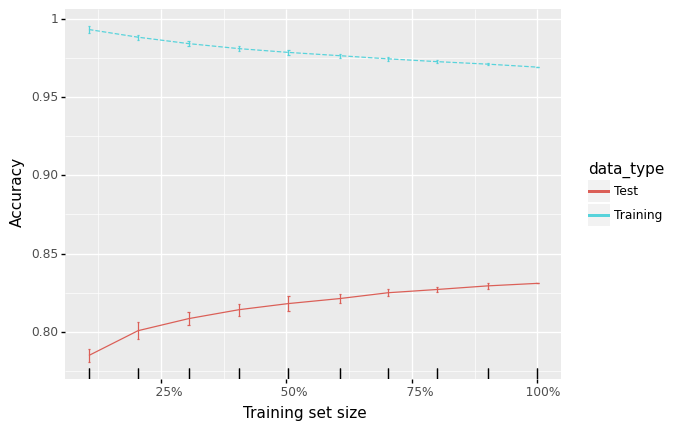

<ggplot: (350614977)>

In [14]:
# Basics of faceting
p = ggplot(sdf) 
p = p + geom_errorbar(aes(x = 'size_mean', ymin = 'accuracy_ue', ymax = 'accuracy_le', color='data_type'))
p = p + geom_line(aes(x='size_mean', y='accuracy_mean', color='data_type', linetype='data_type'))
p = p + scale_x_continuous(
    name = 'Training set size', 
    labels = lambda np_array: ["{:6.0f}%".format(label) for label in np_array])
p = p + scale_y_continuous(name = 'Accuracy', limits = (0,1))
p = p + facet_wrap('data_type')
display(p)

# Basics of rugplots
p = ggplot(sdf) 
p = p + geom_errorbar(aes(x = 'size_mean', ymin = 'accuracy_ue', ymax = 'accuracy_le', color='data_type'))
p = p + geom_line(aes(x='size_mean', y='accuracy_mean', color='data_type', linetype='data_type'))
p = p + scale_x_continuous(
    name = 'Training set size', 
    labels = lambda np_array: ["{:6.0f}%".format(label) for label in np_array])
p = p + scale_y_continuous(name = 'Accuracy')
p = p + geom_rug(aes(x='size_mean'), sides='b')
display(p)

## VI. Combining data from several sources

Sometimes you just cannot fit the entire data into a single data frame:
* You want to overlay averages and actual observations.
* You want to draw different visualisations on top of each other.

To achieve such behaviour without fighting with `ggplot`:
* Specify the main data source in `ggplot()` block.
* Specify additional data sources in geometric objects, e.g. `geom_point(aes(), data=df)`.
* Scaling is done based on the main data source. Other sources are overlayd.

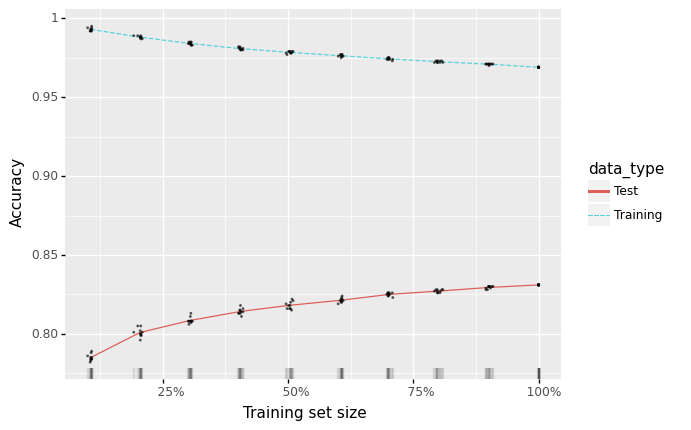

<ggplot: (350612574)>

In [15]:
# Lets overlay average behaviour with detailed observations  
p = ggplot(sdf) 
p = p + geom_line(aes(x = 'size_mean', y = 'accuracy_mean', color = 'data_type', linetype = 'data_type'))

# Visualise setailed observations as points and lines on the rug   
p = p + geom_rug(aes(x = 'size'), data=df, sides='b', alpha=0.1, size=1)
p = p + geom_point(aes(x = 'size', y = 'training_accuracy'), data=df, alpha=0.5, size=0.2)
p = p + geom_point(aes(x = 'size', y = 'test_accuracy'), data=df, alpha=0.5, size=0.2)

p = p + scale_x_continuous(
    name = 'Training set size', 
    labels = lambda np_array: ["{:6.0f}%".format(label) for label in np_array])
p = p + scale_y_continuous(name = 'Accuracy')
display(p)

## VII. Seaborn as  alternative 

* If you want you can use `seaborn` but then you are on your own. 
* In general `seaborn` gives more flexibilty but the cost is complexity. 
* You have to know how `matplotlib` works and some things that are easy in `ggplot` are really hard. 

For example changing the aestetics in `seaborn` facet plots is hard as `seaborn.FacetGrid` provides three channels for spliting data:
* `col` – into which column the data goes
* `ŗow` – into which row the data goes
* `hue` – how the data is colored in the graph

Thus we need to pack different aestetic modifications into `hue` channel and this is not what you want to do. 

Consider the following example data where you want to use 
* `col` and `row` attributes for facets, 
* `method` for defining line style and point type,
* `data_type` for defining color.


In [16]:
df = DataFrame({
    'data_type':['test', 'test', 'train', 'train', 'train'],
    'method':   ['LR', 'LR', 'MV', 'LR', 'MV'],
    'size':     [100, 150, 200, 100, 150],
    'accuracy': [0.70, 0.72, 0.99, 0.92, 0.95],
    'row':      ['A', 'A', 'A', 'A', 'A'],
    'col':      ['A', 'B', 'B', 'A', 'A']})
display(df)

,data_type,method,size,accuracy,row,col
0,test,LR,100,0.70,A,A
1,test,LR,150,0.72,A,B
2,train,MV,200,0.99,A,B
3,train,LR,100,0.92,A,A
4,train,MV,150,0.95,A,A


To continue we must combine two dataframe columns `method` and `data_type` into a single column with values:

* `'LR-test', 'LR-train', 'MV-test', 'MV-train'`.

and describe reverse map for the valus aesthetics known as `hue_kws` in `seaborn`.   

In [17]:
hue_order = ['LR-test', 'LR-train', 'MV-test', 'MV-train']
hue_kws = {
    'color':      ['blue', 'orange', 'blue', 'orange'], 
    'marker':     ['X',    'X',      '.',    '.'],
    'linestyle':  ['-',    '-',      '-.',  '-.']
}

The conversion is not something natural you would like to do.

In [18]:
df = (df
      .assign(hue=lambda df:['{}-{}'.format(data, method) for data, method in zip(df['method'], df['data_type'])])
      .assign(hue=lambda df: df['hue'].astype('category')))
display(df)

,data_type,method,size,accuracy,row,col,hue
0,test,LR,100,0.70,A,A,LR-test
1,test,LR,150,0.72,A,B,LR-test
2,train,MV,200,0.99,A,B,MV-train
3,train,LR,100,0.92,A,A,LR-train
4,train,MV,150,0.95,A,A,MV-train


Now we are finally ready do draw the faceted graph.

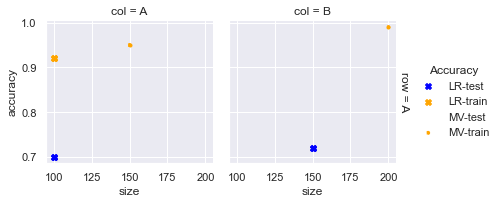

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")
fg = sns.FacetGrid(df, col="col", row="row", hue = "hue", 
                   hue_order=hue_order, hue_kws=hue_kws, 
                   margin_titles = True)
fg.map(plt.plot, "size", "accuracy", marker ='s')
fg.map(plt.scatter, "size", "accuracy")
fg.add_legend(title = "Accuracy")

As one can see the corresponding graph building is much more technical but on the same time more flexible.

**Documentation sources**

https://wckdouglas.github.io/2016/12/seaborn_annoying_title  
https://stackoverflow.com/questions/32899463/how-can-i-overlay-two-graphs-in-seaborn  
https://stackoverflow.com/questions/44261803/change-line-style-in-seaborn-facet-grid  
https://matplotlib.org/gallery/lines_bars_and_markers/line_styles_reference.html